In [1]:
%cd '/app'

/app


/home/user/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import yaml 
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import sys
sys.path.append('src')

import argparse
import re 
from src.loader.checkpoint import load_pretrained_bag

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

In [ ]:
def _visualize_embedding(cont_range, C, center=0, save_path=None, field_name='QQ'):

    mag = np.linalg.norm(C, axis=-1)
    Cn = C / np.linalg.norm(C, axis=-1, keepdims=True)
    M = C @ C.T
    Mn = Cn @ Cn.T
    D = torch.cdist(torch.tensor(M), torch.tensor(M))
    
    # plt.figure(figsize=(10, 5))
    # norm
    plt.figure(figsize=(5, 5))
    plt.plot(cont_range, mag, linewidth=2.5)
    plt.axvline(cont_range[center], color='grey', linestyle='dashed', linewidth=2.5)
    plt.title(f'Norm of embedding vectors ({field_name})', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'Norm_{field_name}.pdf'))
    plt.show()

    plt.figure(figsize=(5, 5))  
    plt.imshow(D, extent=[cont_range.min()-0.5, cont_range.max()+0.5, cont_range.max()-0.5, cont_range.min()+0.5])
    plt.title(f'Distance heatmap', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'Distance_{field_name}.pdf'))
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.plot(cont_range, D[center], linewidth=2.5)
    plt.axvline(cont_range[center], color='grey', linestyle='dashed', linewidth=2.5)
    plt.title(f'Distance map slice at {cont_range[center]:.1f}', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'DistanceSlice_{cont_range[center]}_{field_name}.pdf'))
    plt.show()

    # correlation matrix  
    plt.figure(figsize=(5, 5))  
    plt.imshow(Mn, extent=[cont_range.min()-0.5, cont_range.max()+0.5, cont_range.max()-0.5, cont_range.min()+0.5])
    plt.title(f'Dot-product heatmap (normalized)', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'NormalizedDotProd_{field_name}.pdf'))
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.plot(cont_range, Mn[center], linewidth=2.5)
    plt.axvline(cont_range[center], color='grey', linestyle='dashed', linewidth=2.5)
    plt.title(f'Heat map slice at {cont_range[center]:.1f}', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'NormalizedDotProdSlice_{cont_range[center]}_{field_name}.pdf'))
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(M, extent=[cont_range.min()-0.5, cont_range.max()+0.5, cont_range.max()-0.5, cont_range.min()+0.5])
    plt.title(f'Dot-product heatmap', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'DotProd_{field_name}.pdf'))
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.plot(cont_range, M[center], linewidth=2.5)
    plt.axvline(cont_range[center], color='grey', linestyle='dashed', linewidth=2.5)
    plt.title(f'Heat map slice at {cont_range[center]:.1f}', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    if save_path is not None: plt.savefig(os.path.join(save_path, f'DotProdSlice_{cont_range[center]}_{field_name}.pdf'))
    plt.show()

    
def visualize_embedding(model, field, save_dir=None, forced_center=None):
    is_finite_field = field[:2] == 'GF'
    
    if is_finite_field:
        field_order = int(field[2:])
    xmin = 0 if is_finite_field else -25
    xmax = field_order  if is_finite_field else 25

    cont_range = torch.arange(xmin, xmax, 0.1)

    if forced_center is not None:
        center = ((cont_range - forced_center)**2).argmin()
    else:
        center = ((cont_range - field_order/2)**2).argmin() if is_finite_field else cont_range.shape[0] // 2

    x_cont = cont_range.reshape(1, -1, 1).cuda()
    x = torch.zeros(1, x_cont.size(1)).long().cuda()
    C = model.input_embedding(x, x_cont).squeeze(0).cpu().detach().numpy()

    _visualize_embedding(cont_range, C, center=center, save_path=save_dir, field_name=field)


def visualize_embedding_disrete(model, tokenizer, field, save_dir=None, forced_center=None):
    is_finite_field = field[0] == 'F'
    
    if is_finite_field:
        field_order = int(field[1:])

    xmin = 0 if is_finite_field else -25
    xmax = field_order  if is_finite_field else 25

    if is_finite_field:
        number_tokens = np.array([i for i in range(field_order) if i != 1])
    else:
        number_tokens = np.array(list(range(-100, 101)))
    number_token_ids = [tokenizer.vocab[f'C{i}'] for i in number_tokens]
    embedding = model.input_embedding.d_embedding.weight

    ### embedding
    C = embedding[number_token_ids].detach().cpu()

    cont_range = number_tokens
    if forced_center is not None:
        center = ((cont_range - forced_center)**2).argmin()
    else:
        center = ((cont_range - field_order/2)**2).argmin() if is_finite_field else cont_range.shape[0] // 2

    _visualize_embedding(cont_range, C, center=center, save_path=save_dir, field_name=field)

    

In [8]:
for field in ['GF7', 'GF31', 'QQ', 'RR']:
    n = 2

    dataset_name = f'shape_dataset_n={n}_field={field}'
   
    model_path = f'results/shape/hybrid_bart+/{field}_n=2'
    bag = load_pretrained_bag(model_path)
    model, tokenizer = bag['model'], bag['tokenizer']

    save_path = f'results/visualizing_continuous_embedding/{dataset_name}-C'
    os.makedirs(save_path, exist_ok=True)
    visualize_embedding(model, field, save_dir=save_path, forced_center=0)

FileNotFoundError: [Errno 2] No such file or directory: 'results/shape/hybrid_bart+/{field}_n=2/params.yaml'

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


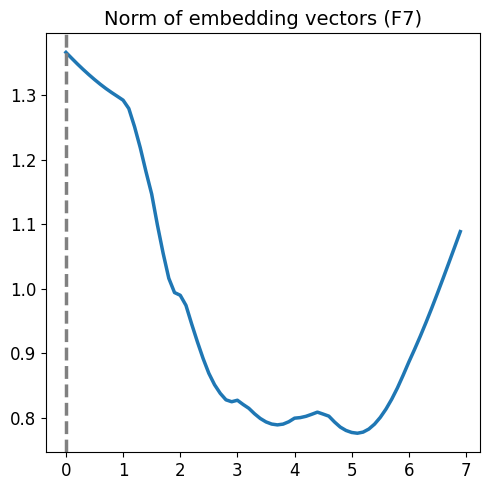

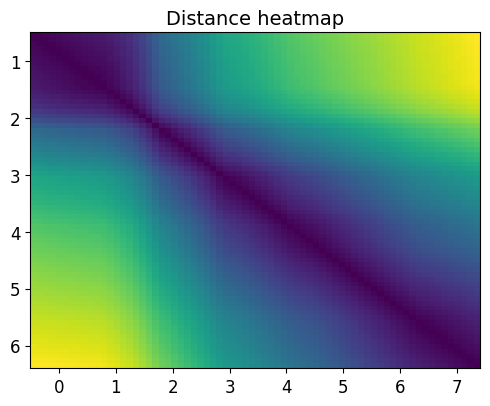

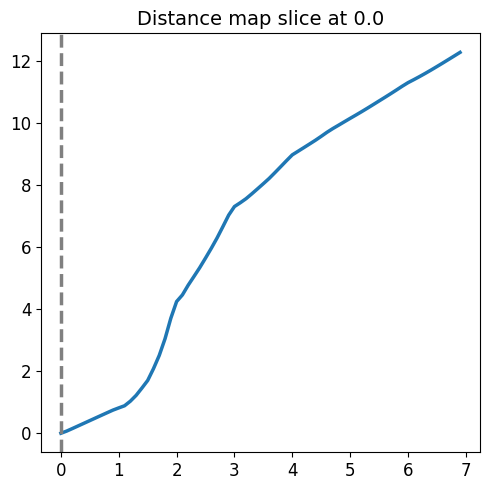

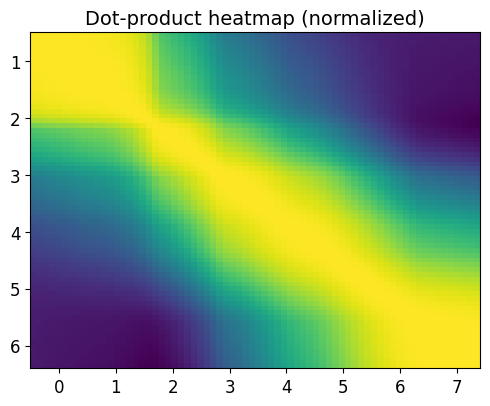

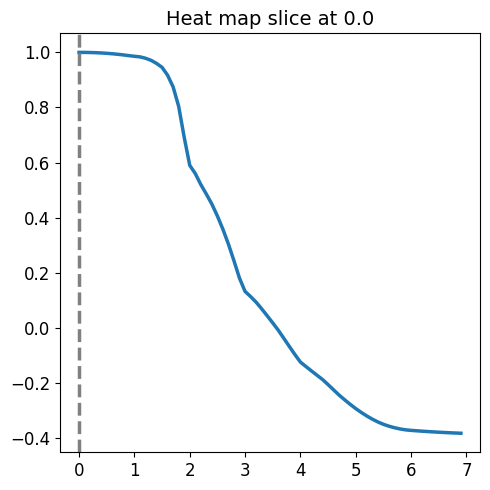

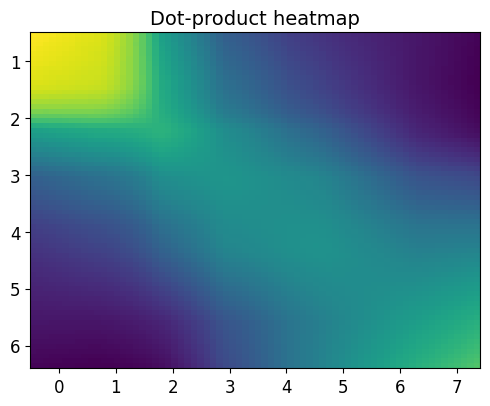

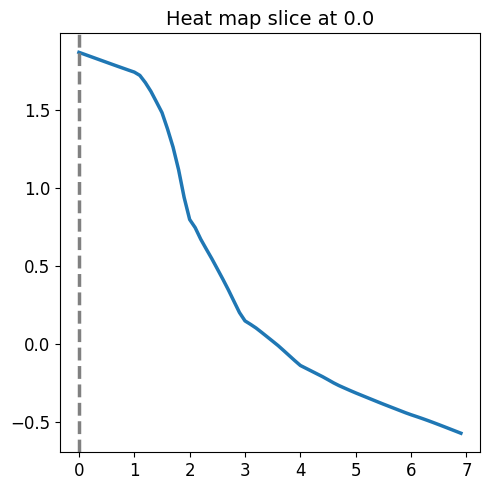

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


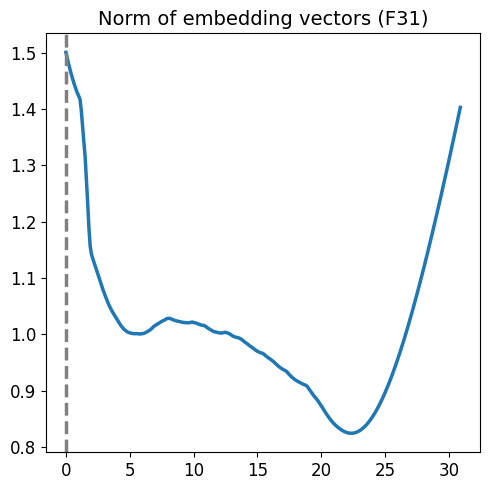

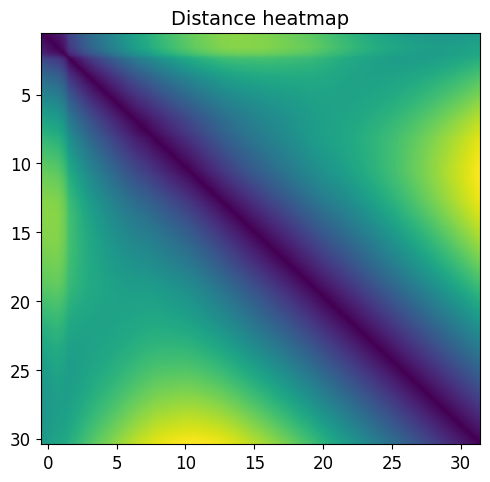

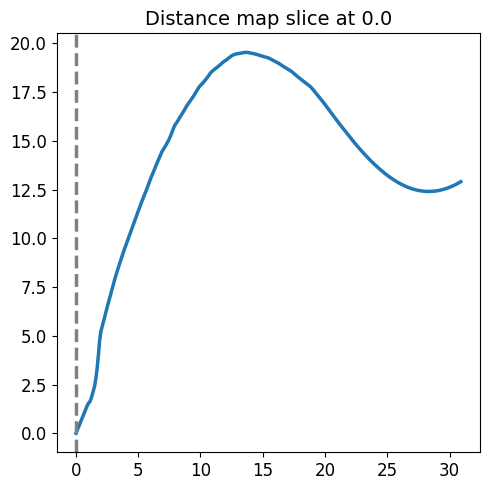

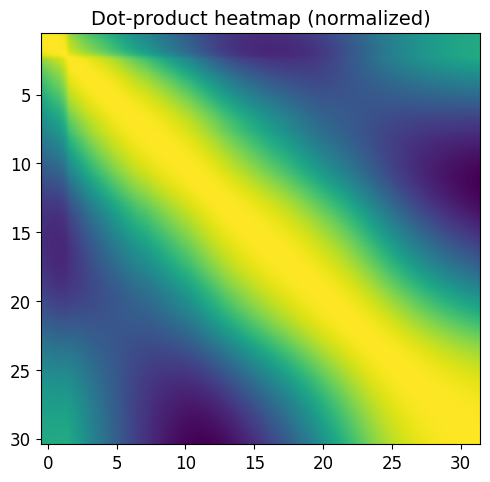

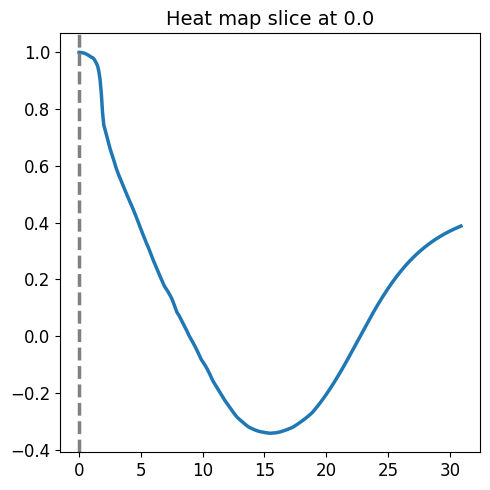

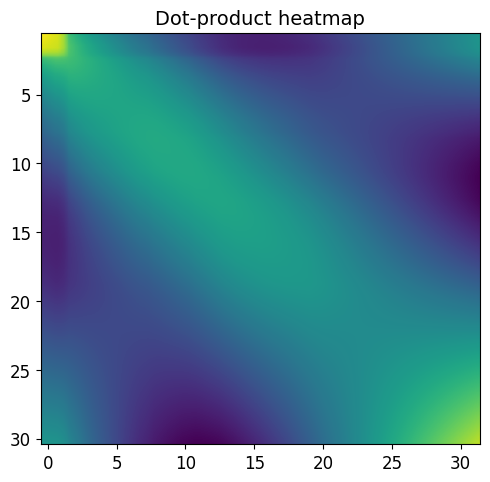

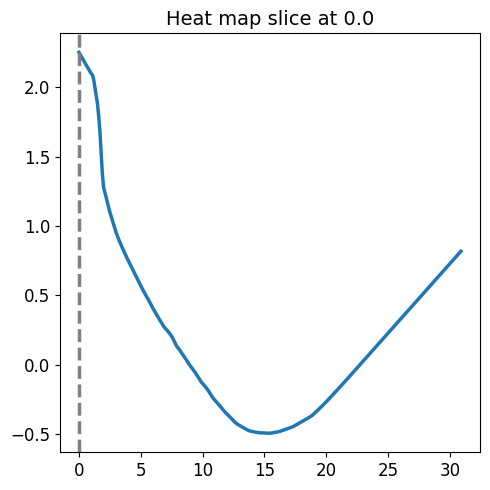

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


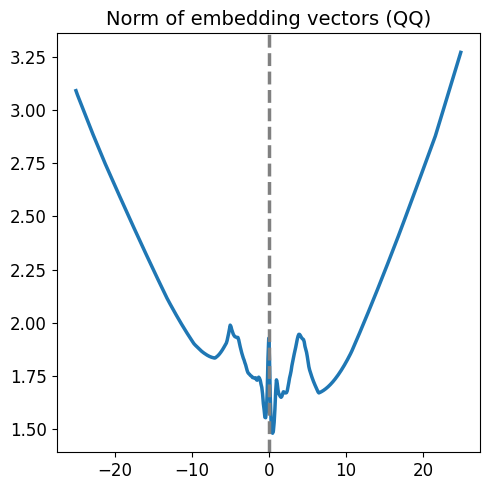

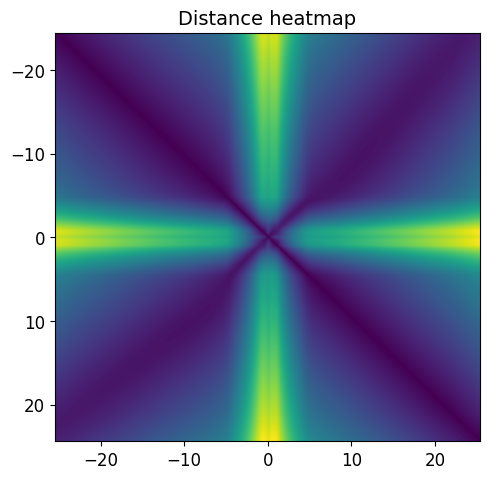

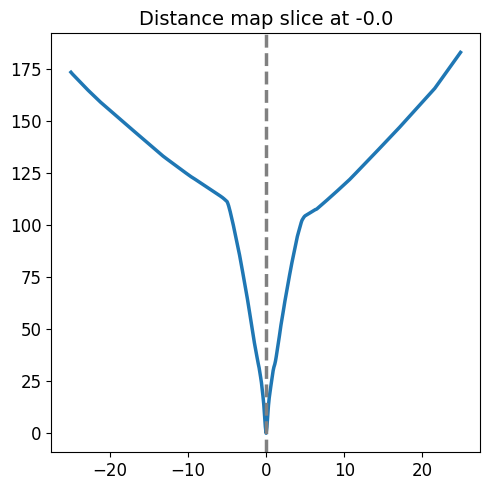

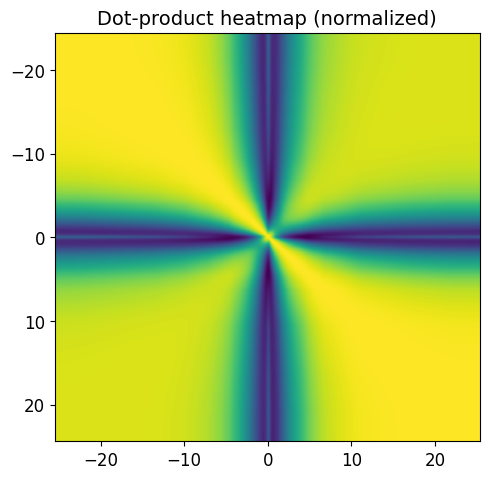

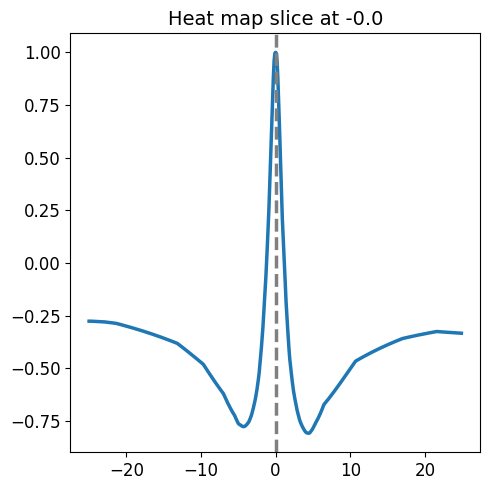

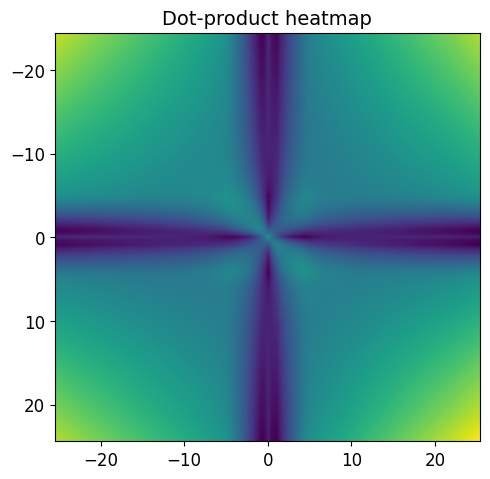

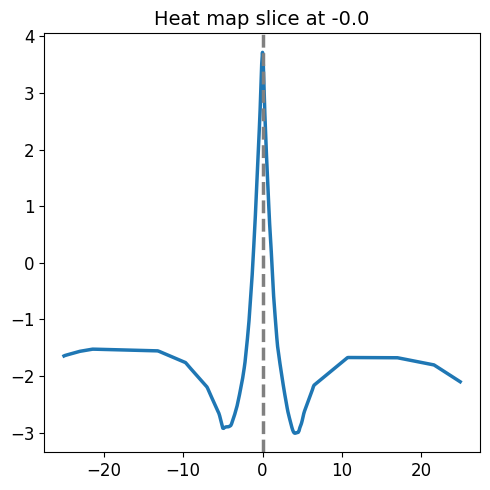

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


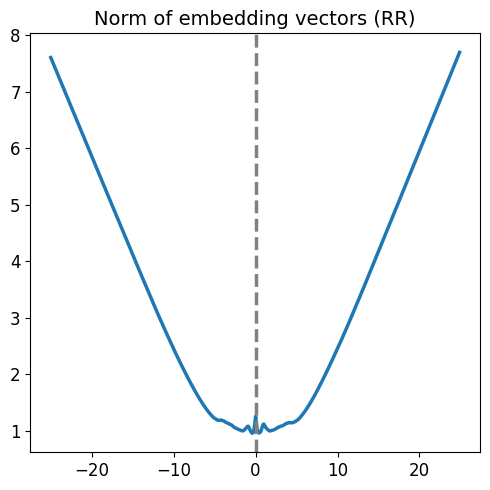

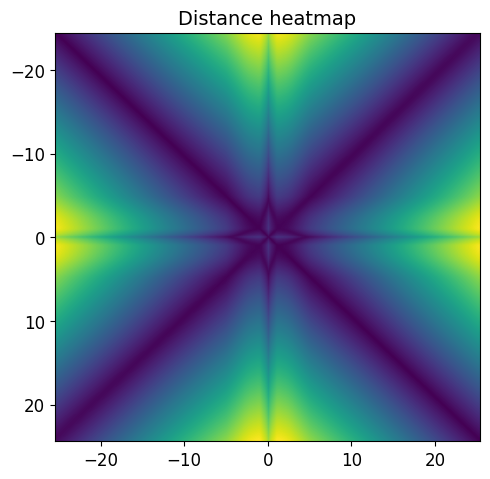

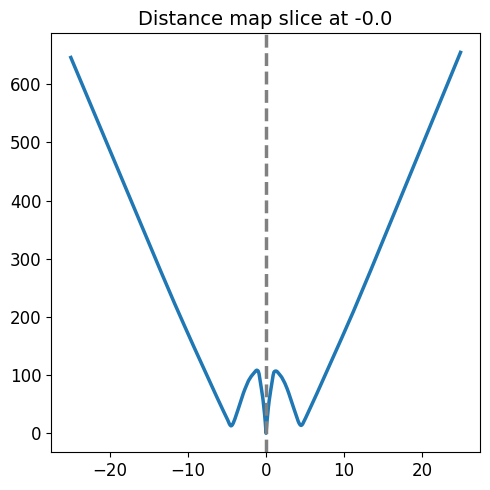

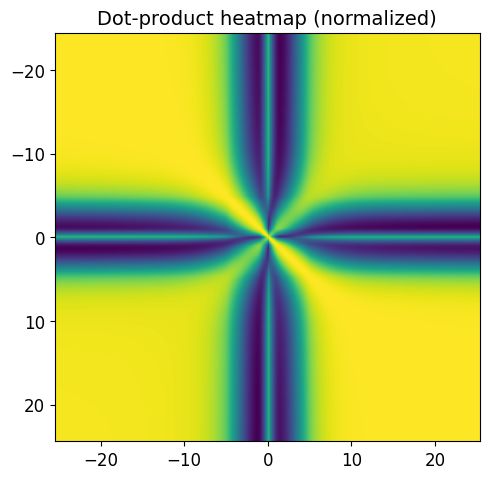

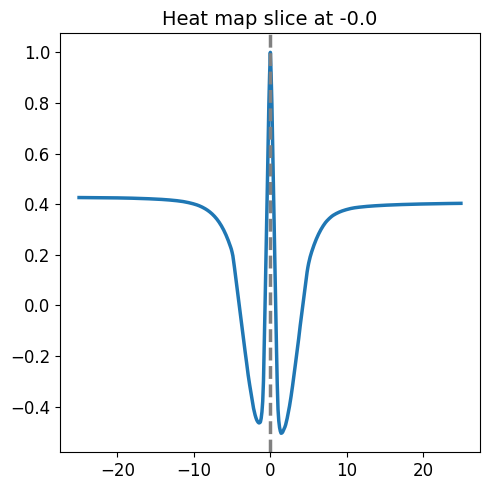

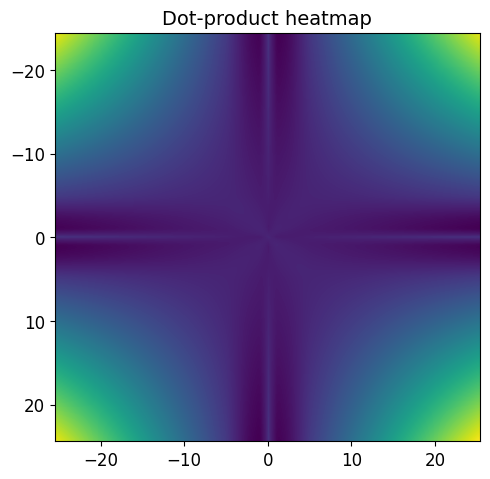

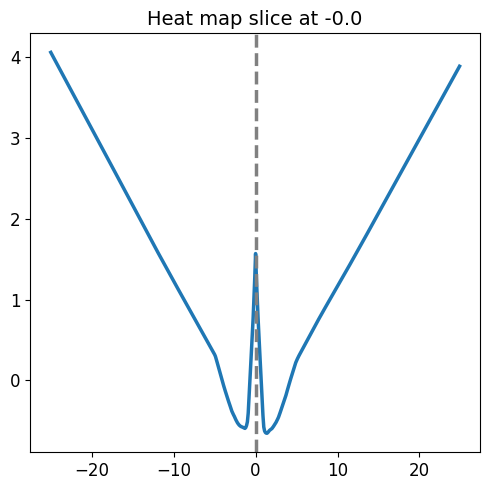

In [39]:
for field in ['F7', 'F31', 'QQ', 'RR']:
    n = 2

    dataset_name = f'gb_dataset_n={n}_field={field}'
    save_dir = f'/app/results2/shape_gb_lex/regression_weights=0.01/{dataset_name}-C-ffn2'
    data_dir = f'/app/data_dev/{dataset_name}/data'

    bag = load_trained_bag(save_dir, from_checkpoint=False, model_name='bart+')
    model = bag['model']
    tokenizer = bag['tokenizer']
    params = bag['params']

    save_path = f'results2/embedding_vis-ffn2/{dataset_name}-C'
    os.makedirs(save_path, exist_ok=True)
    visualize_embedding(model, field, save_dir=save_path, forced_center=0)

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.
/tmp/ipykernel_2373996/421216148.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.cdist(torch.tensor(M), torch.tensor(M))


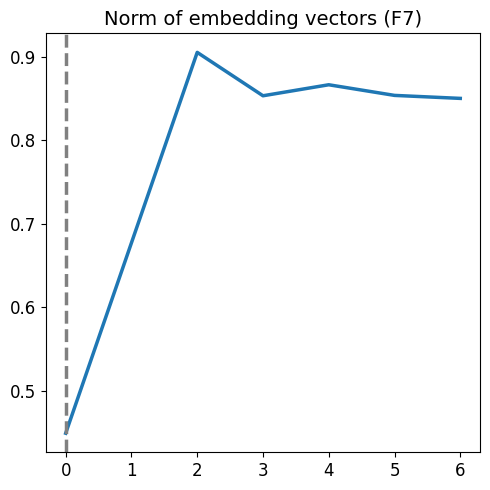

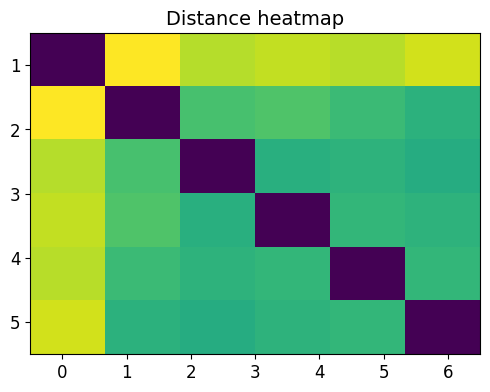

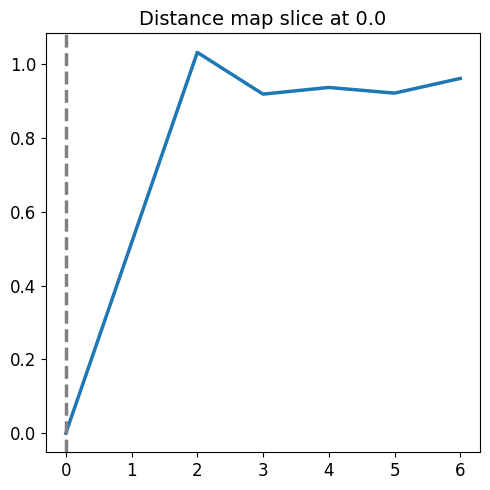

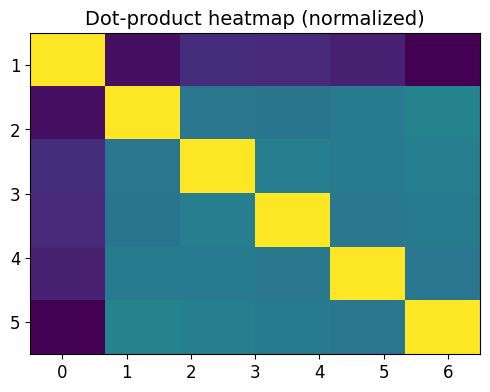

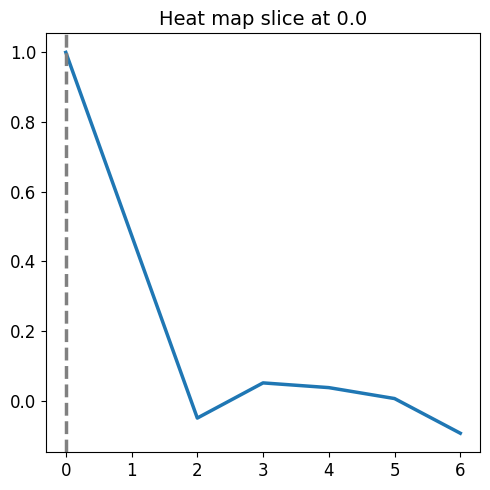

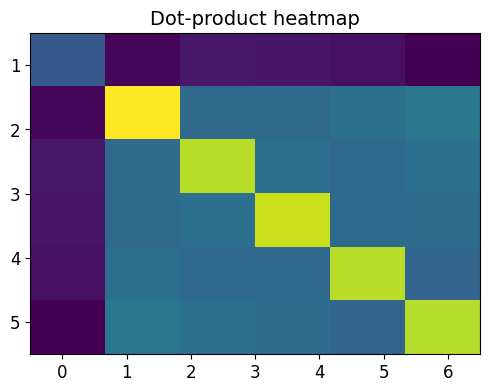

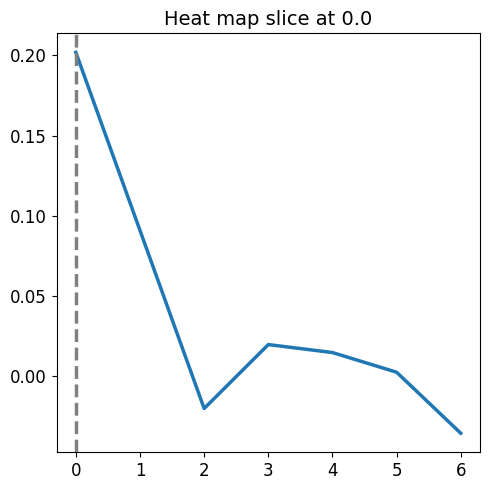

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.
/tmp/ipykernel_2373996/421216148.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.cdist(torch.tensor(M), torch.tensor(M))


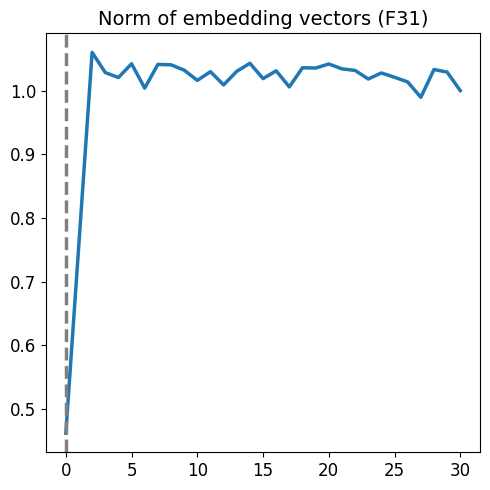

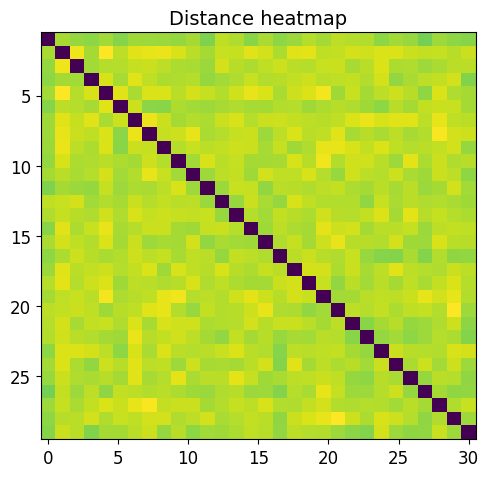

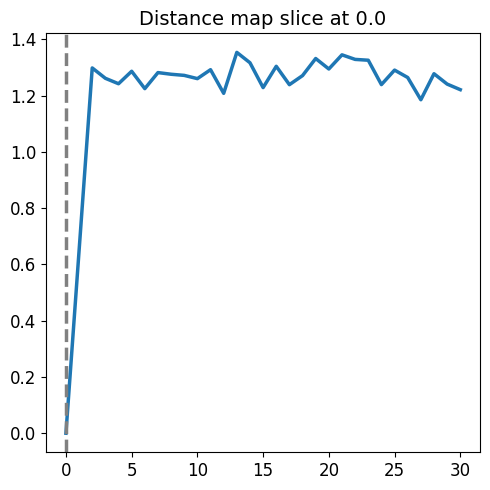

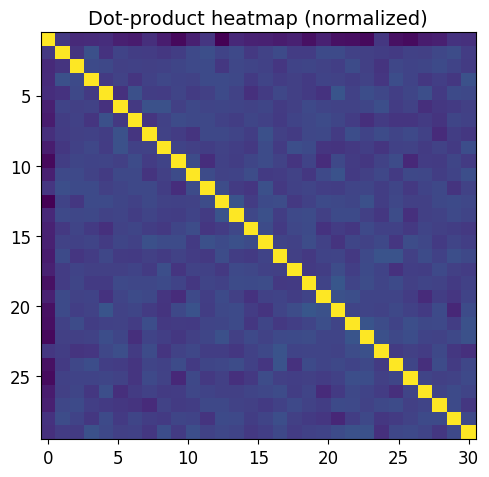

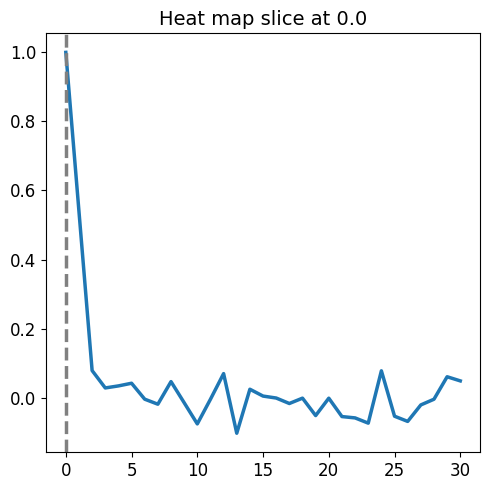

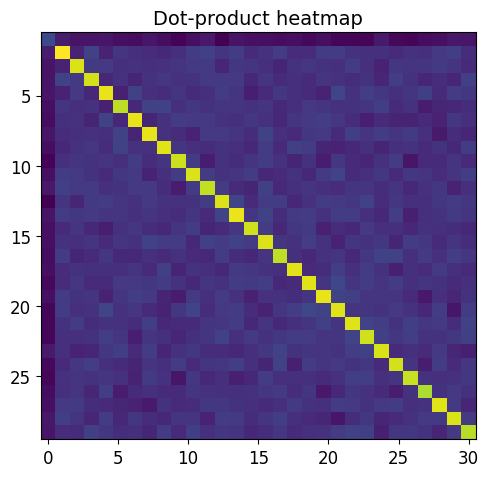

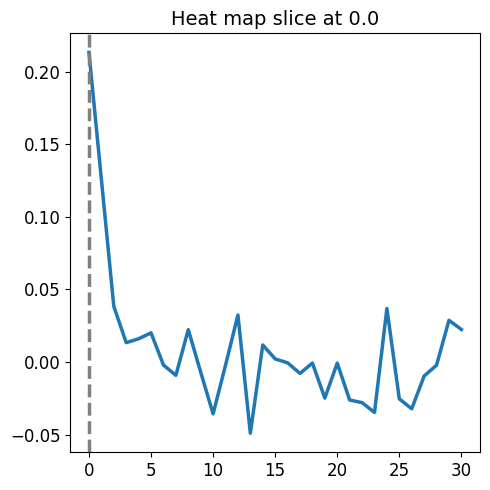

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.
/tmp/ipykernel_2373996/421216148.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.cdist(torch.tensor(M), torch.tensor(M))


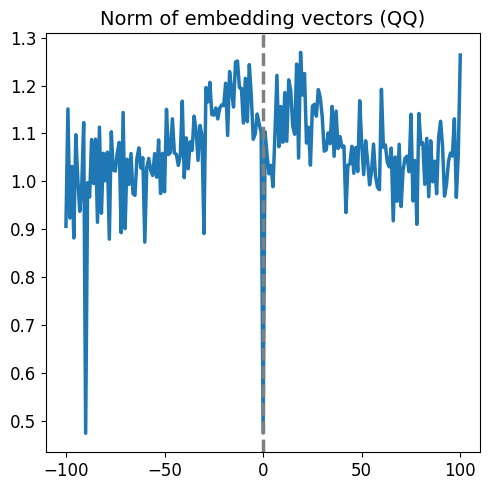

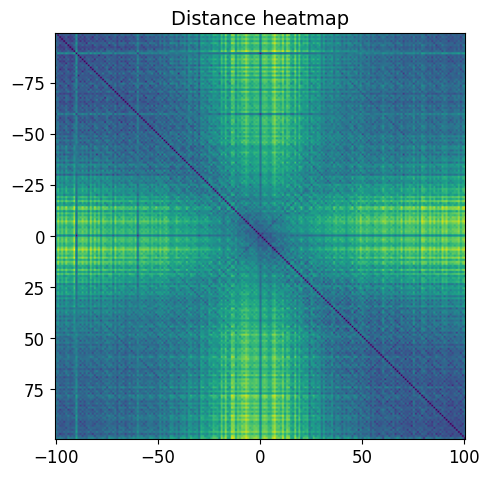

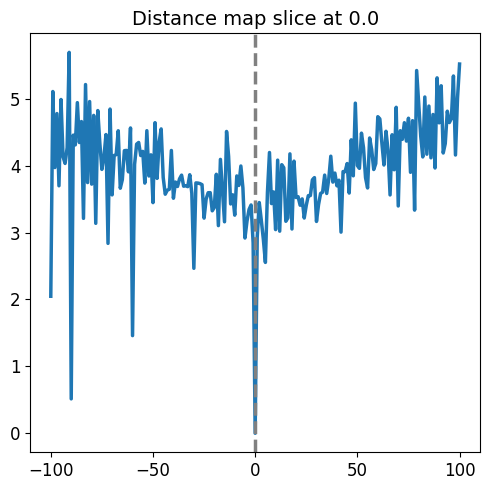

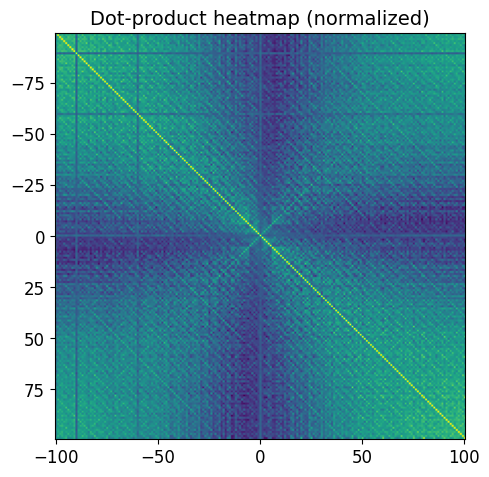

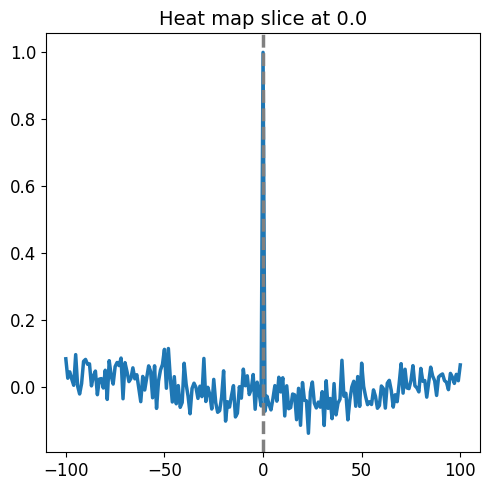

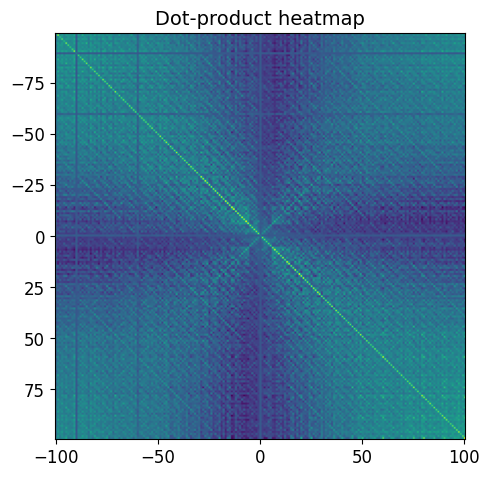

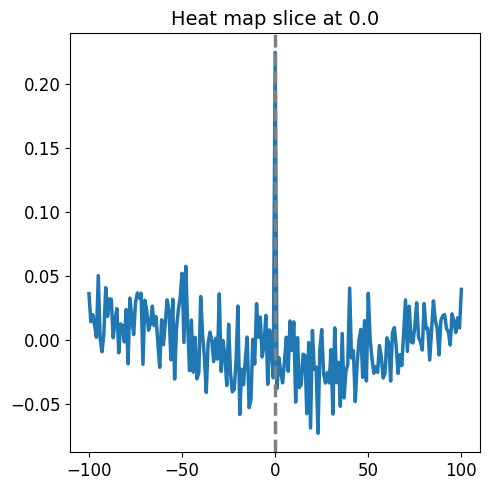

In [40]:
for field in ['F7', 'F31', 'QQ']:
    n = 2

    dataset_name = f'gb_dataset_n={n}_field={field}'
    save_dir = f'/app/results2/shape_gb_lex/{dataset_name}'
    data_dir = f'/app/data_dev/{dataset_name}/data'

    bag = load_trained_bag(save_dir, from_checkpoint=False, model_name='bart+')
    model = bag['model']
    tokenizer = bag['tokenizer']
    params = bag['params']

    save_path = f'results2/embedding_vis/{dataset_name}'
    os.makedirs(save_path, exist_ok=True)
    visualize_embedding_disrete(model, tokenizer, field, save_dir=save_path, forced_center=0)